In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import init_simple_mdp as imdp
import numpy as np
import seaborn as sns
from matplotlib import cm, colors


In [102]:
def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = colors.rgb2hex(rgb)
    return color

In [9]:
df = pd.read_csv('player10_results.csv')
df = df[['epsilon','tokens','score','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

## 1.0 Calculate Spot Dart Handicaps

In [84]:
epsilon_list = list(df.epsilon.unique())
epsilon_list = list(range(1,11))

In [85]:
expected_throws_list = []
for epsilon in epsilon_list: 
    th = df.loc[(df.score==501) & (df.epsilon==epsilon) & (df.tokens==0)].optimal_value.values[0]
    expected_throws_list.append(th)

ppd_list = [501 / expected_throws_list[i] for i in range(len(expected_throws_list))]


In [86]:
ssl_list = []

for i in range(len(ppd_list)):

    for j in range(i,len(ppd_list)):

        hppd = ppd_list[i]
        lppd = ppd_list[j]

        ssl = round(501*(lppd/hppd))

        ssl_list.append([epsilon_list[i],epsilon_list[j],ssl])

#ssl_list

In [87]:
ssl_list_full = []

for ssl in ssl_list: 

    th1 = df.loc[(df.score==501) & (df.epsilon==ssl[0]) & (df.tokens==0)].optimal_value.values[0]
    th2 = df.loc[(df.score==ssl[2]) & (df.epsilon==ssl[1]) & (df.tokens==0)].optimal_value.values[0]

    ssl_list_full.append([ssl[0],ssl[1],ssl[2],th1,th2, th2-th1])

In [88]:
spot_point_df = pd.DataFrame(ssl_list_full,columns=['p1_epsilon','p2_epsilon','p2_starting_score','p1_expected_throws','p2_expected_throws','diff_expected_throws'])
spot_point_df.head()

,p1_epsilon,p2_epsilon,p2_starting_score,p1_expected_throws,p2_expected_throws,diff_expected_throws
0,1,1,501,15.854003,15.854003,0.000000
1,1,2,376,15.854003,16.606544,0.752541
2,1,3,311,15.854003,17.276087,1.422085
3,1,4,274,15.854003,18.018940,2.164937
4,1,5,248,15.854003,18.723984,2.869981


## 2. Relationship between PPD and Execution Error

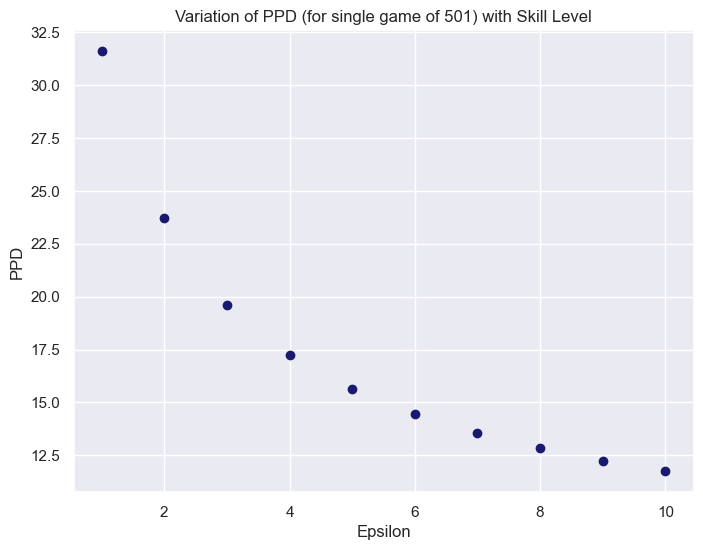

In [114]:
fig = plt.scatter(epsilon_list,ppd_list,color='midnightblue')
fig = plt.xlabel('Epsilon')
fig = plt.ylabel('PPD')
fig = plt.title("Variation of PPD (for single game of 501) with Skill Level")


## 3. Equalization Error for Variance Differences in Skill Level 

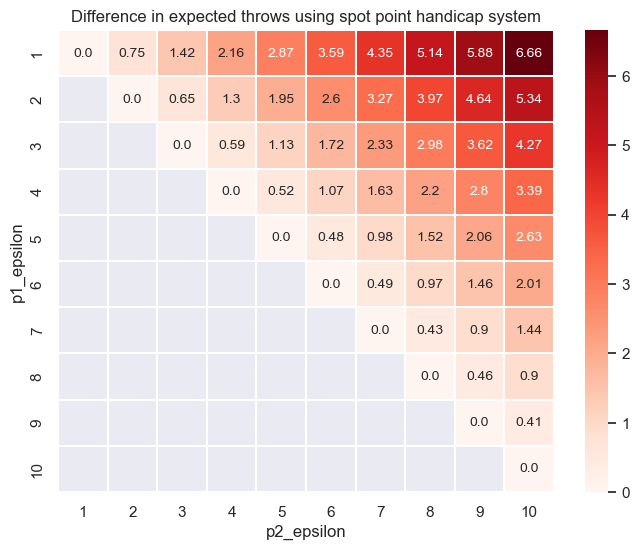

In [90]:
result = spot_point_df.pivot(index='p1_epsilon',columns='p2_epsilon',values='diff_expected_throws')
result = result.round(2)
#print(result)
#sns.heatmap(result,annot=labels,fmt="",cmap='RdYlGn',linewidths=0.30,ax=ax)
fig = sns.set(rc={'figure.figsize':(8,6)})
fig = sns.heatmap(result,annot=True,annot_kws={"size": 10},fmt="",cmap='Reds',linewidths=0.30)
fig = plt.title("Difference in expected throws using spot point handicap system")

## 4. Change in PPD as the Game Progresses

In [95]:
df0 = df.loc[df.tokens==0].copy()
df0['ppd'] = df0.score / df0.optimal_value

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for epsilon in range(1,11):
    
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['ppd'].copy()
    epsilon_dfs.append(temp)


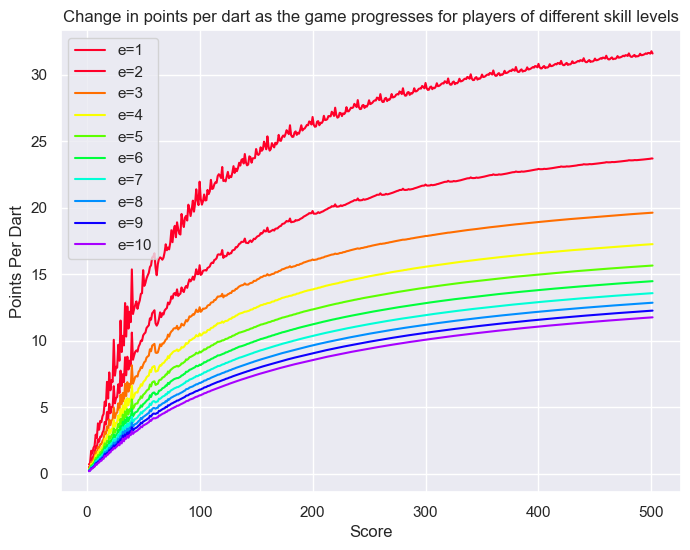

In [111]:
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

# Plot each token line 
for epsilon in range(0,10):
    e_leg.append('e={}'.format(epsilon+1))
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_dfs[epsilon],color=color)

fig = plt.title('Change in points per dart as the game progresses for players of different skill levels')
fig = plt.xlabel('Score')
fig = plt.ylabel('Points Per Dart')
fig = plt.legend(e_leg)

## 5. Effectiveness of Spot Point Handicap at Creating Competitive Balance

In [115]:
df0 = df.loc[df.tokens==0].copy()
df0['ppd'] = df0.score / df0.optimal_value

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for epsilon in range(1,11):
    
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_value'].copy()
    epsilon_dfs.append(temp)


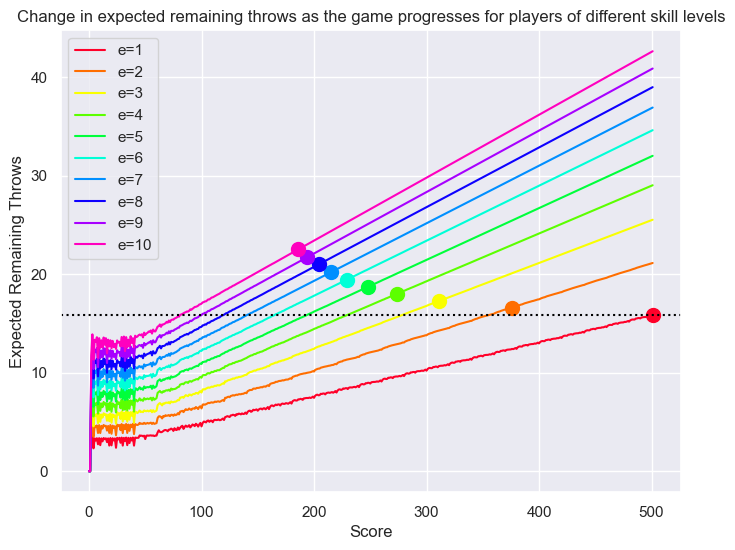

In [136]:
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

# Plot each token line 
for epsilon in range(10):
    e_leg.append('e={}'.format(epsilon+1))
    color = color_map_color(epsilon+1, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_dfs[epsilon],color=color)

fig = plt.legend(e_leg) 

for epsilon in range(10):
    color = color_map_color(epsilon+1, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    s = spot_point_df.loc[(spot_point_df.p1_epsilon==1) & (spot_point_df.p2_epsilon==epsilon+1)]['p2_starting_score'].values[0]
    fig = plt.plot(s, epsilon_dfs[epsilon][s], marker="o", markersize=10, color=color)


fig = plt.title('Change in expected remaining throws as the game progresses for players of different skill levels')
fig = plt.xlabel('Score')
fig = plt.axhline(epsilon_dfs[0][501],color='black',linestyle='dotted') 
fig = plt.ylabel('Expected Remaining Throws')
fig = plt.legend(e_leg)